In [219]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import cluster
from tqdm import tqdm

In [3]:
data = pd.read_csv('../data/men_velodata.csv')
data.columns

Index(['name', 'stage', 'points_scale', 'parcours_type', 'year', 'month',
       'day', 'type', 'length', 'profile_score', 'avg_speed',
       'vertical_meters', 'won_how', 'place', 'rider', 'team', 'age', 'time'],
      dtype='object')

In [108]:
# extract data for each stage into a dictionary
stage_data = {} 
for i in tqdm(data.index):

    if data.loc[i, 'type'] not in ['standard', 'itt']:
        continue

    race = data.loc[i, 'name']
    year = data.loc[i, 'year']

    try:
        stage = int(data.loc[i, 'stage'].split('-')[1])
    except:
        continue

    if (race, year) not in stage_data:
        stage_data[(race, year)] = {}
    
    if stage not in stage_data[(race, year)]:

        stage_data[(race, year)][stage] = {
            'points_scale': data.loc[i, 'points_scale'],
            'parcours_type': data.loc[i, 'parcours_type'],
            'race_type': data.loc[i, 'type'],
            'race_length': data.loc[i, 'length'],
            'profile_score': data.loc[i, 'profile_score'],
            'avg_speed': data.loc[i, 'avg_speed'],
            'vertical_meters': data.loc[i, 'vertical_meters'],
            'winner': data.loc[i, 'rider']
        }

# convert stage data into a df
stage_df = {'name': [], 'year': [], 'stage': [], 'points_scale': [], 'parcours_type': [], 'race_type': [], 'race_length': [], 'profile_score': [], 'avg_speed': [], 'vertical_meters': [], 'winner': []}
for race, year in stage_data:
    for stage in stage_data[(race, year)]:
        stage_df['name'].append(race)
        stage_df['year'].append(year)
        stage_df['stage'].append(stage)
        for key in stage_data[(race, year)][stage]:
            stage_df[key].append(stage_data[(race, year)][stage][key])

stage_df = pd.DataFrame(stage_df)
stage_df

100%|██████████| 634880/634880 [00:17<00:00, 37257.86it/s]


,name,year,stage,points_scale,parcours_type,race_type,race_length,profile_score,avg_speed,vertical_meters,winner
0,tour-de-france,2020.0,1,GT.A.Stage,p2,standard,156.0,46.0,41.35 km/h,1597.0,KRISTOFF Alexander
1,tour-de-france,2020.0,2,GT.A.Stage,p4,standard,185.0,188.0,37.57 km/h,4066.0,ALAPHILIPPE Julian
2,tour-de-france,2020.0,3,GT.A.Stage,p2,standard,198.0,81.0,37.39 km/h,3003.0,EWAN Caleb
3,tour-de-france,2020.0,4,GT.A.Stage,p5,standard,160.5,200.0,38.86 km/h,3200.0,ROGLIČ Primož
4,tour-de-france,2020.0,5,GT.A.Stage,p1,standard,183.0,31.0,42.01 km/h,1388.0,VAN AERT Wout
...,...,...,...,...,...,...,...,...,...,...,...
3754,tour-of-the-alps,2022.0,1,2.PRO.Stage,p4,standard,160.9,227.0,38.254 km/h,3693.0,BOUCHARD Geoffrey
3755,tour-of-the-alps,2022.0,2,2.PRO.Stage,p4,standard,154.1,153.0,39.167 km/h,3228.0,BILBAO Pello
3756,tour-of-the-alps,2022.0,3,2.PRO.Stage,p5,standard,154.6,193.0,38.183 km/h,3287.0,KÄMNA Lennard
3757,tour-of-the-alps,2022.0,4,2.PRO.Stage,p5,standard,142.4,159.0,40.867 km/h,2386.0,LÓPEZ Miguel Ángel


In [106]:
# prepare stage data to plot in 2d
def prepare_stage_data(stage_df, races, years, drop_tt = True):

    races_df = pd.DataFrame()
    stage_annots = []
    for race, year in zip(races, years):
        race_df = stage_df[stage_df['name'] == race]
        race_df = race_df[race_df['year'] == year]
        stage_annot = list(zip(race_df['name'], race_df['year'].astype(int), race_df['stage'], race_df['winner']))

        # edit columns, numerify features, and normalize
        race_df = race_df[['parcours_type', 'race_type', 'race_length', 'vertical_meters']]
        race_df.replace(['p0', 'p1', 'p2', 'p3', 'p4', 'p5'], range(6), inplace = True)
        race_df.replace(['standard', 'itt'], [0, 1], inplace = True)

        if drop_tt:
            race_df = race_df[rafe_df['race_type'] != 'itt']
        
        
        races_df = pd.concat([races_df, race_df])
        stage_annots += stage_annot
    
    
    races_df = pd.DataFrame(normalize(races_df.to_numpy(), axis = 0), columns = races_df.columns)
    return races_df, stage_annots

In [217]:
# plot stage profiles in 2d
def plot_2d(race_df, stage_annots = None):

    embedder = PCA(n_components = 2)
    latent = embedder.fit_transform(race_df.to_numpy())
    latent = [[t[0] for t in latent], [t[1] for t in latent]]

    fig, ax = plt.subplots(figsize = (12, 20))
    ax.scatter(latent[0], latent[1])

    # label the plot with winners if winners are given
    if stage_annots is not None:
        for i, annot in enumerate(stage_annots):
            ax.annotate(annot, (latent[0][i], latent[1][i]))
    
    plt.show()

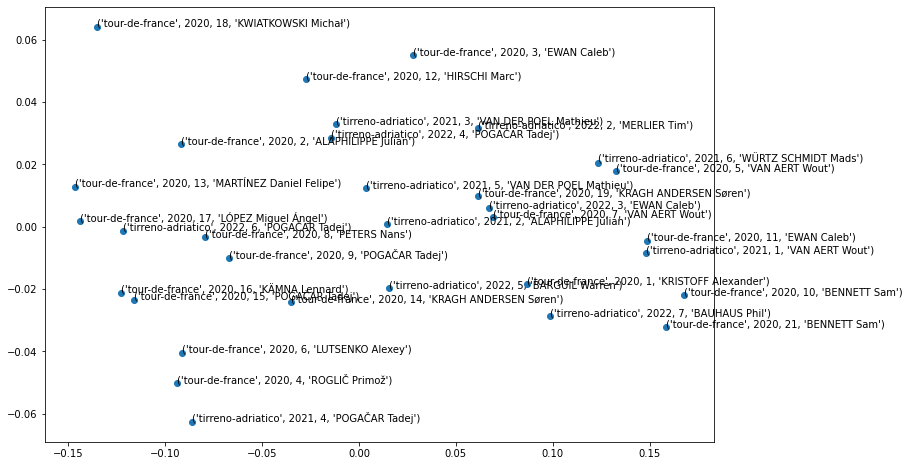

In [103]:
latent, stage_annots = prepare_stage_data(stage_df, ['tirreno-adriatico', 'tirreno-adriatico', 'tour-de-france'], [2021, 2022, 2020])
plot_2d(latent, stage_annots)

In [224]:
# aggregate stats for races
def agg_race_stats(stages_df, race, year):

    race_df = stages_df[stages_df['name'] == race]
    race_df = race_df[race_df['year'] == year]

    race_data = {}

    # get race features
    pc_counts = race_df['parcours_type'].value_counts()
    race_data['is_gt'] = [0 if len(race_df.index) < 15 else 1]
    race_data['num_p0'] = [pc_counts['p0'] if 'p0' in pc_counts else 0]
    race_data['num_p1'] = [pc_counts['p1'] if 'p1' in pc_counts else 0]
    race_data['num_p2'] = [pc_counts['p2'] if 'p2' in pc_counts else 0]
    race_data['num_p3'] = [pc_counts['p3'] if 'p3' in pc_counts else 0]
    race_data['num_p4'] = [pc_counts['p4'] if 'p4' in pc_counts else 0]
    race_data['num_p5'] = [pc_counts['p5'] if 'p5' in pc_counts else 0]
    
    # race_data['mean_vert'] = [np.mean(race_df['vertical_meters'])]
    # race_data['std_vert'] = [np.std(race_df['vertical_meters'])]
    # race_data['max_vert'] = [max(race_df['vertical_meters'])]
    # race_data['mean_length'] = [np.mean(race_df['race_length'])]
    # race_data['std_length'] = [np.std(race_df['race_length'])]
    # race_data['max_length'] = [max(race_df['race_length'])]

    itt_df = race_df[race_df['race_type'] == 'itt']
    race_data['num_itt'] = [len(itt_df.index)]
    race_data['itt_kms'] = [sum(itt_df['race_length'])]

    return pd.DataFrame(data = race_data, index = [0])

def combine_data(data_lst, reduce_dims = True, normalize_data = True):
    data = pd.concat(data_lst)

    if normalize_data:
        data = normalize(data.to_numpy(), axis = 0)

    if reduce_dims:
        embedder = PCA(n_components = 2)
        data = pd.DataFrame(embedder.fit_transform(data))
    
    return data

In [221]:
np.unique(stage_df[stage_df['year'] == 2021]['name'])

array(['adriatica-ionica-race', 'arctic-race-of-norway', 'benelux-tour',
       'boucles-de-la-mayenne', 'czech-cycling-tour', 'dauphine',
       'deutschland-tour', 'etoile-de-besseges', 'giro-d-italia',
       'itzulia-basque-country', 'la-route-d-occitanie',
       'okolo-slovenska', 'paris-nice', 'ruta-del-sol',
       'settimana-ciclistica-italiana',
       'settimana-internazionale-coppi-e-bartali', 'sibiu-cycling-tour',
       'tirreno-adriatico', 'tour-cycliste-international-la-provence',
       'tour-de-france', 'tour-de-hongrie', 'tour-de-l-ain',
       'tour-de-luxembourg', 'tour-de-pologne', 'tour-de-romandie',
       'tour-de-suisse', 'tour-de-wallonie',
       'tour-des-alpes-maritimes-et-du-var', 'tour-du-limousin',
       'tour-du-poitou-charentes-et-de-la-vienne', 'tour-of-belgium',
       'tour-of-britain', 'tour-of-denmark', 'tour-of-norway',
       'tour-of-rwanda', 'tour-of-slovenia', 'tour-of-the-alps',
       'tour-of-turkey', 'uae-tour', 'volta-a-catalunya',
   

,0,1
0,-7.234290,-0.732006
1,-7.162705,0.063203
2,4.026355,-0.774138
3,-7.168153,-1.440528
4,-7.275404,0.492873


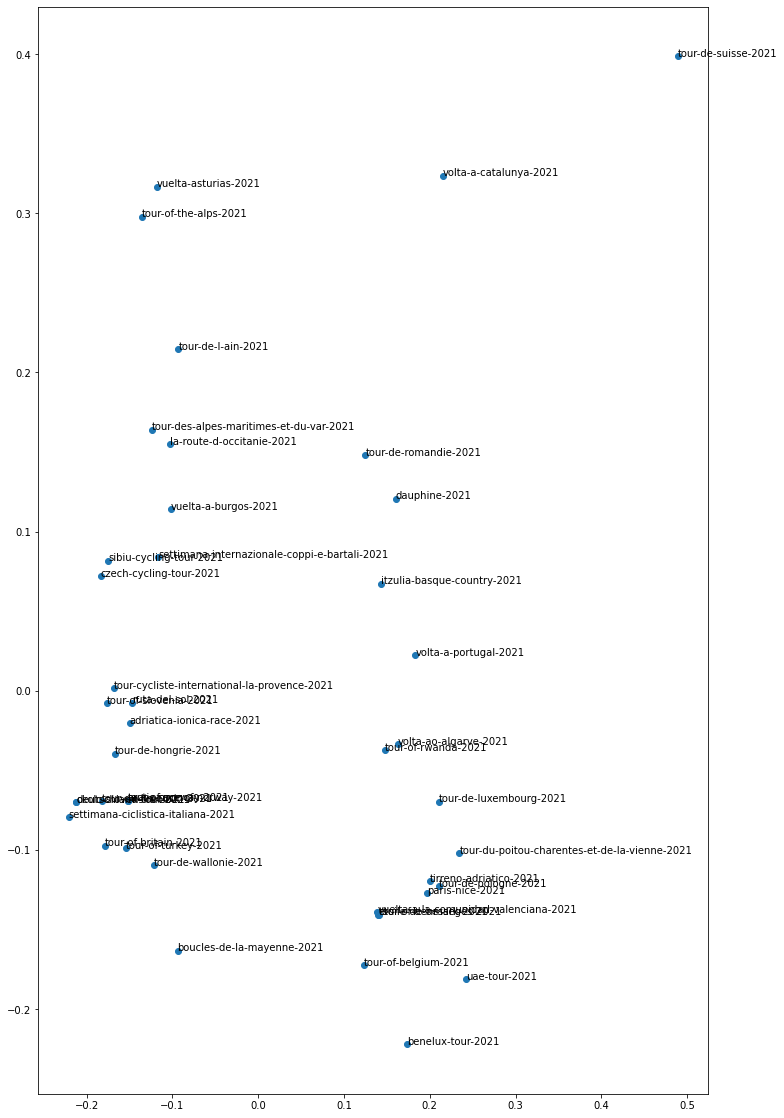

In [234]:
races = ['adriatica-ionica-race', 'arctic-race-of-norway', 'benelux-tour',
       'boucles-de-la-mayenne', 'czech-cycling-tour', 'dauphine',
       'deutschland-tour', 'etoile-de-besseges',
       'itzulia-basque-country', 'la-route-d-occitanie',
       'okolo-slovenska', 'paris-nice', 'ruta-del-sol',
       'settimana-ciclistica-italiana',
       'settimana-internazionale-coppi-e-bartali', 'sibiu-cycling-tour',
       'tirreno-adriatico', 'tour-cycliste-international-la-provence',
       'tour-de-hongrie', 'tour-de-l-ain',
       'tour-de-luxembourg', 'tour-de-pologne', 'tour-de-romandie',
       'tour-de-suisse', 'tour-de-wallonie',
       'tour-des-alpes-maritimes-et-du-var', 'tour-du-limousin',
       'tour-du-poitou-charentes-et-de-la-vienne', 'tour-of-belgium',
       'tour-of-britain', 'tour-of-denmark', 'tour-of-norway',
       'tour-of-rwanda', 'tour-of-slovenia', 'tour-of-the-alps',
       'tour-of-turkey', 'uae-tour', 'volta-a-catalunya',
       'volta-a-portugal', 'volta-ao-algarve', 'vuelta-a-burgos',
       'vuelta-a-la-comunidad-valenciana',
       'vuelta-asturias']
years = [2021]
to_plot = [(r, y) for r in races for y in years]
agg_stats = [
    agg_race_stats(stage_df, r, y) for r, y in to_plot
]
combined = combine_data(agg_stats, normalize_data = False)
display(combined.head(5))
latent = combine_data(agg_stats)
plot_2d(latent, [f'{r}-{y}' for r, y in to_plot])

In [229]:
normalized = combine_data(agg_stats, reduce_dims = False)
dbscan = cluster.KMeans().fit(normalized)
dbscan.labels_

array([7, 3, 1, 1, 7, 2, 3, 1, 2, 0, 3, 1, 7, 3, 0, 7, 1, 7, 7, 0, 4, 4,
       2, 6, 3, 0, 3, 4, 1, 3, 1, 3, 5, 7, 0, 7, 1, 2, 2, 2, 0, 1, 0],
      dtype=int32)

In [233]:
labels = {}
for r, label in zip(races,dbscan.labels_):
    if label not in labels:
        labels[label] = [r]
    else:
        labels[label].append(r)
labels

{7: ['adriatica-ionica-race',
  'czech-cycling-tour',
  'ruta-del-sol',
  'sibiu-cycling-tour',
  'tour-cycliste-international-la-provence',
  'tour-de-hongrie',
  'tour-of-slovenia',
  'tour-of-turkey'],
 3: ['arctic-race-of-norway',
  'deutschland-tour',
  'okolo-slovenska',
  'settimana-ciclistica-italiana',
  'tour-de-wallonie',
  'tour-du-limousin',
  'tour-of-britain',
  'tour-of-norway'],
 1: ['benelux-tour',
  'boucles-de-la-mayenne',
  'etoile-de-besseges',
  'paris-nice',
  'tirreno-adriatico',
  'tour-of-belgium',
  'tour-of-denmark',
  'uae-tour',
  'vuelta-a-la-comunidad-valenciana'],
 2: ['dauphine',
  'itzulia-basque-country',
  'tour-de-romandie',
  'volta-a-catalunya',
  'volta-a-portugal',
  'volta-ao-algarve'],
 0: ['la-route-d-occitanie',
  'settimana-internazionale-coppi-e-bartali',
  'tour-de-l-ain',
  'tour-des-alpes-maritimes-et-du-var',
  'tour-of-the-alps',
  'vuelta-a-burgos',
  'vuelta-asturias'],
 4: ['tour-de-luxembourg',
  'tour-de-pologne',
  'tour-du-po